In [1]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, TimeDistributed, GlobalAveragePooling2D,
                                     Bidirectional, LSTM, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Paths and constants
data_path = "/mnt/d/Group50/Facial_Emotion_Recongnition/Datasets/VideoDataset2" 
OUTPUT_PATH = "processed_videos"
MAX_FRAMES = 30
IMG_SIZE = (64, 64)
BATCH_SIZE = 8

In [3]:
# Load metadata
with open(os.path.join(OUTPUT_PATH, "metadata_encoded.json"), "r") as f:
    metadata = json.load(f)

In [4]:
# Label info
labels = [item["label"] for item in metadata]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Assign encoded labels
for i, item in enumerate(metadata):
    item["label_encoded"] = int(y_encoded[i])

In [5]:
# Train/val split
train_meta, val_meta = train_test_split(metadata, test_size=0.2, random_state=42)


In [6]:
# Data Generator
class VideoDataGenerator(Sequence):
    def __init__(self, metadata, batch_size, num_classes, data_path, shuffle=True):
        self.metadata = metadata
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.data_path = data_path
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))

    def __getitem__(self, index):
        batch_metadata = self.metadata[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_metadata)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.metadata)

    def __data_generation(self, batch_metadata):
        X = []
        y = []
        for item in batch_metadata:
            frames = np.load(os.path.join(self.data_path, f"{item['video_id']}.npy"))
            X.append(frames)
            y.append(item["label_encoded"])
        return np.array(X), to_categorical(y, num_classes=self.num_classes)


In [7]:
# Create generators
train_gen = VideoDataGenerator(train_meta, BATCH_SIZE, num_classes, OUTPUT_PATH)
val_gen = VideoDataGenerator(val_meta, BATCH_SIZE, num_classes, OUTPUT_PATH)


In [8]:
# Build model
base_cnn = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
base_cnn.trainable = False  # Freeze CNN for now

input_layer = Input(shape=(MAX_FRAMES, IMG_SIZE[1], IMG_SIZE[0], 3))
x = TimeDistributed(base_cnn)(input_layer)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(128, dropout=0.3, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [12]:
# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)


Epoch 1/10
1029/1029 [==============================] - 358s 348ms/step - loss: 1.4933 - accuracy: 0.4062 - val_loss: 1.1639 - val_accuracy: 0.5659 - lr: 0.0010
Epoch 2/10
1029/1029 [==============================] - 344s 334ms/step - loss: 1.0906 - accuracy: 0.5896 - val_loss: 0.8549 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 3/10
1029/1029 [==============================] - 344s 335ms/step - loss: 0.8291 - accuracy: 0.6926 - val_loss: 0.7563 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 4/10
1029/1029 [==============================] - 345s 335ms/step - loss: 0.6834 - accuracy: 0.7529 - val_loss: 0.7052 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 5/10
1029/1029 [==============================] - 346s 337ms/step - loss: 0.6038 - accuracy: 0.7777 - val_loss: 0.6510 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 6/10
1029/1029 [==============================] - 345s 335ms/step - loss: 0.5278 - accuracy: 0.8089 - val_loss: 0.6595 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 7/10
1029/1029 [============

# Save
model.save("cnn_Bilstm_model.h5")
print("✅ Model trained and saved!")

c:\Users\deie\anaconda3\envs\condaenv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model trained and saved!


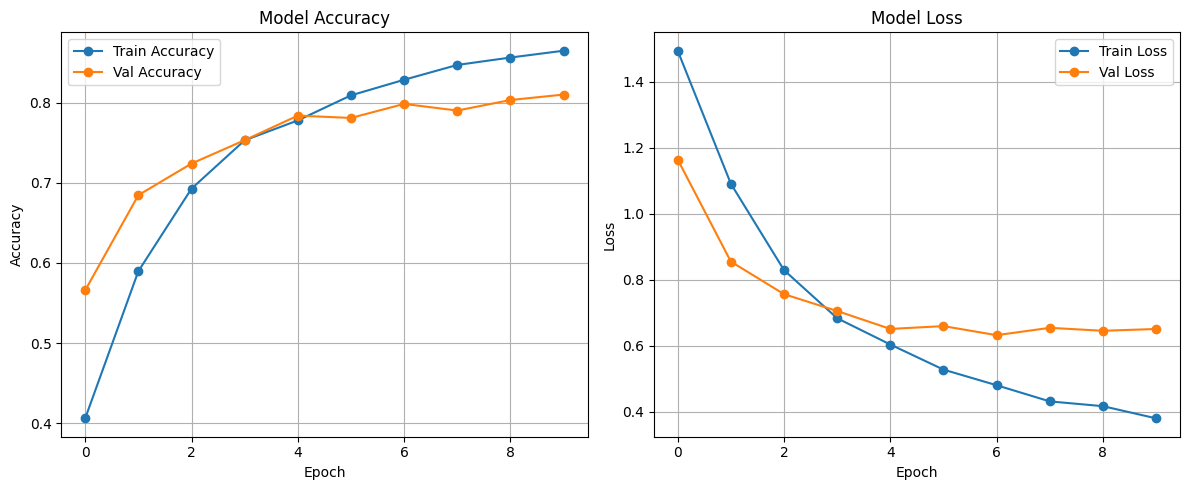

In [13]:
# Save
model.save("cnn_Bilstm_model4.h5")
print("✅ Model trained and saved!")
# Plot Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
